# M1 MIAGE SBD
##@Authors : Aline N'DEKO & Franck LAGOU
## Kickstarter for final project "Differential privacy"

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp
import seaborn as sns
import numpy as np
from numpy.random import laplace


## Loading data

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'

names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
         'marital-status', 'occupation', 'relationship', 'race',
         'gender', 'capital-gain', 'capital-loss', 'hours-per-week',
         'native-country', 'income']

adult = pd.read_csv(url, sep=',', header=None, names=names, na_values='?', engine='python', skipinitialspace=True)

adult.dropna(inplace=True)
adult

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


## Performing queries

### Query H1: Distribution (histogram) of the education level.

In [3]:
adult['education'].value_counts()

education
HS-grad         9840
Some-college    6678
Bachelors       5044
Masters         1627
Assoc-voc       1307
11th            1048
Assoc-acdm      1008
10th             820
7th-8th          557
Prof-school      542
9th              455
12th             377
Doctorate        375
5th-6th          288
1st-4th          151
Preschool         45
Name: count, dtype: int64

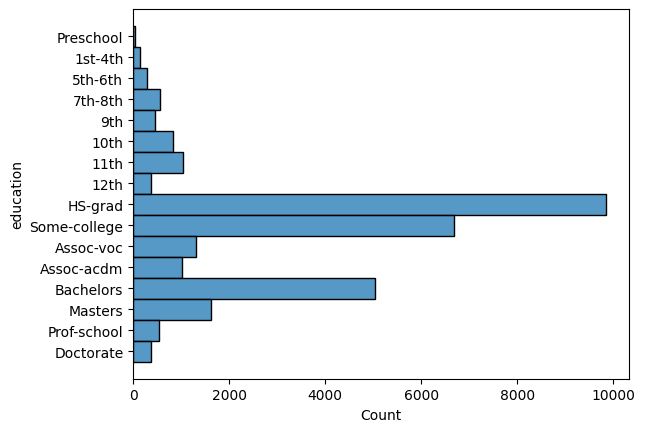

In [4]:
sns.histplot(data=adult.sort_values(by='education-num'), y='education');

## I- Privelet Algorithm

#### Q1 : Implement the 1-dimensional Privelet algorithm described in the Section 4 “Privelet for one-dimensional
ordinal data”

In [5]:
import numpy as np
from numpy.random import laplace

# === Étape 1 : Transformation de Haar Wavelet ===
def haar_wavelet_transform(data):
    """
    Applique la Haar Wavelet Transform (HWT) à une liste de données.
    Retourne les coefficients (base + internes).
    """
    data = np.array(data, dtype=float)
    n = len(data)
    coeffs = []

    def build_tree(segment):
        if len(segment) == 1:
            return segment[0]
        mid = len(segment) // 2
        left_avg = np.mean(segment[:mid])
        right_avg = np.mean(segment[mid:])
        coeff = (left_avg - right_avg) / 2
        coeffs.append(coeff)
        build_tree(segment[:mid])
        build_tree(segment[mid:])
        return coeff

    # Base coefficient (c0) = moyenne globale
    base_coeff = np.mean(data)
    coeffs.insert(0, base_coeff)
    build_tree(data)
    return coeffs


In [6]:
# === Étape 3
def compute_whaar_weights(num_coeffs):
    """
    Calcule les poids WHaar des coefficients pour Privelet.
    Cette version corrige les problèmes de boucles infinies et assure que num_coeffs est une puissance de 2.
    """
    # Vérification que num_coeffs est une puissance de 2
    if (num_coeffs & (num_coeffs - 1)) != 0:  # Si ce n'est pas une puissance de 2
        raise ValueError("num_coeffs doit être une puissance de 2")
    
    weights = []
    l = int(np.log2(num_coeffs))  # Calcul de l
    
    weights.append(2**l)  # Le poids du coefficient de base (c0)
    
    level = 1
    remaining = num_coeffs - 1  # Reste à traiter après le coefficient de base
    
    while remaining > 0:
        # Calcul du nombre de nœuds à ce niveau
        nodes_at_level = 2**(level - 1)
        
        # Ajouter des poids pour chaque nœud à ce niveau
        for _ in range(nodes_at_level):
            if len(weights) < num_coeffs:
                weights.append(2**(l - level + 1))
        
        # Réduire le nombre restant à traiter
        remaining -= nodes_at_level
        level += 1
    
    return weights


In [7]:
import numpy as np
from numpy.random import laplace

# === Étape 3 : Ajout du bruit Laplacien calibré ===
def add_laplace_noise(coeffs, epsilon):
    """
    Ajoute du bruit Laplacien aux coefficients Haar en fonction de WHaar.
    """
    weights = compute_whaar_weights(len(coeffs))
    noisy_coeffs = []
    lambda_ = (1 + np.log2(len(weights))) / epsilon  # Très important
    for c, w in zip(coeffs, weights):
        scale = lambda_ / w  # Ajustement correct
        noisy_coeffs.append(c + laplace(scale=scale))
    return noisy_coeffs


In [8]:
import numpy as np
from numpy.random import laplace
# === Étape 4 : Reconstruction des données originales ===
def inverse_haar_wavelet_transform(coeffs):
    """
    Reconstitue les données à partir des coefficients Haar.
    """
    n = len(coeffs)  # nombre total de coefficients (ici 8)
    levels = int(np.log2(n))  # le nombre de niveaux

    # Initialiser les valeurs avec le premier coefficient (la moyenne)
    reconstructed = np.array([coeffs[0]])

    # Décoder chaque niveau et doubler la taille à chaque fois
    idx = 1
    for level in range(levels):
        new_reconstructed = []
        for val in reconstructed:
            diff = coeffs[idx]
            new_reconstructed.append(val + diff)
            new_reconstructed.append(val - diff)
            idx += 1
        reconstructed = np.array(new_reconstructed)

    return reconstructed


In [9]:
import numpy as np
from numpy.random import laplace

# === Privelet Algorithm (Final Function) ===
def privelet_transform(data, epsilon):
    """
    Implémente le Privelet transform (1D) pour données ordinales.
    """
    coeffs = haar_wavelet_transform(data)
    noisy_coeffs = add_laplace_noise(coeffs, epsilon)
    noisy_data = inverse_haar_wavelet_transform(noisy_coeffs)
    return noisy_data, noisy_coeffs


In [10]:

# Données de test (longueur = 8 = 2^3)
original_data = [9, 3, 6, 2, 8, 4, 5, 7]
epsilon = 1.0  # niveau de confidentialité

print("=== Données originales ===")
print(original_data)

=== Données originales ===
[9, 3, 6, 2, 8, 4, 5, 7]


In [11]:

# Étape 1 : Transformation de Haar
coeffs = haar_wavelet_transform(original_data)
print("\n=== Coefficients Haar ===")
print(np.round(coeffs, 3))


=== Coefficients Haar ===
[ 5.5 -0.5  1.   3.   2.   0.   2.  -1. ]


In [12]:
# Étape 2 : Poids WHaar
weights = compute_whaar_weights(len(coeffs))
print("\n=== Poids WHaar ===")
print(weights)


=== Poids WHaar ===
[8, 8, 4, 4, 2, 2, 2, 2]


In [13]:
# Étape 3 : Ajout de bruit
noisy_coeffs = add_laplace_noise(coeffs, epsilon)
print("\n=== Coefficients bruités ===")
print(np.round(noisy_coeffs, 2))


=== Coefficients bruités ===
[ 5.44 -0.46 -0.57  2.87  2.41 -8.62  1.19  2.14]


In [14]:

# Reconstruction des données à partir des coefficients bruités
data_reconstructed_by_coeff = inverse_haar_wavelet_transform(noisy_coeffs)

print("\n=== Données reconstruites (bruitées) ===")
print(np.round(data_reconstructed_by_coeff, 2))


=== Données reconstruites (bruitées) ===
[ 6.82  2.   -3.08 14.17  9.96  7.58  5.17  0.89]


In [15]:
# Comparaison avec reconstruction sans bruit (pour valider l’algo)
perfect_reconstruction = inverse_haar_wavelet_transform(coeffs)
print("\n=== Reconstruction sans bruit (pour validation) ===") 
print(np.round(perfect_reconstruction, 2))


=== Reconstruction sans bruit (pour validation) ===
[ 8.  4.  4.  4. 11.  7.  2.  4.]


#### Q2: Test your code with Privelet to compute query H1 with ² 2 {0.01,0.1,1}


On doit :

Extraire la colonne "education",

Construire l'histogramme (compter combien par niveau d'éducation),

Appliquer Privelet (Haar + bruit Laplace + inverse),

Tester pour epsilon ∈ {0.01, 0.1, 1},

Imprimer les résultats.

In [16]:
# Extraire l'histogramme "education"
education_counts = adult['education'].value_counts().sort_index()
labels = education_counts.index.tolist()
edu_true_histogram = education_counts.values
edu_true_histogram

array([ 820, 1048,  377,  151,  288,  557,  455, 1008, 1307, 5044,  375,
       9840, 1627,   45,  542, 6678])

In [17]:
#
def pad_to_power_of_two(arr):
    next_pow2 = 2**int(np.ceil(np.log2(len(arr))))
    padded = np.zeros(next_pow2)
    padded[:len(arr)] = arr
    return padded

edu_original_data = pad_to_power_of_two(edu_true_histogram)

edu_original_data


array([ 820., 1048.,  377.,  151.,  288.,  557.,  455., 1008., 1307.,
       5044.,  375., 9840., 1627.,   45.,  542., 6678.])

In [18]:
#Tester pour différents epsilon
edu_epsilons = [0.01, 0.1, 1]

for edu_epsilon in edu_epsilons:
    print(f"\n==================================== Résultats pour ε = {edu_epsilon} =================================")

    # 1-Appliquer Haar
    edu_coeffs = haar_wavelet_transform(edu_original_data)

    # 2-Calculer poids
    edu_weights = compute_whaar_weights(len(edu_coeffs))

    # 3-Ajouter bruit Laplace
    edu_noisy_coeffs = add_laplace_noise(edu_coeffs, edu_epsilon)
    
    # 4-Reconstruire l'histogramme bruité
    edu_reconstructed = inverse_haar_wavelet_transform(edu_noisy_coeffs)
    
    # 🔥 Ajouter affichage
    print("Histogramme reconstruit bruité :")
    print(np.round(edu_reconstructed, 2))



==================================== Résultats pour ε = 0.01 =================================
Histogramme reconstruit bruité :
[  396.54   898.83  2368.47  -703.44  -277.02  1282.58 -2239.65  3548.47
 -1893.76  8402.76  2457.71  4630.86  4000.17  1241.4     33.71  6033.99]

==================================== Résultats pour ε = 0.1 =================================
Histogramme reconstruit bruité :
[  250.33   737.39  1674.88  -310.12  -266.78  1633.89 -1380.38  2347.99
 -1462.63  8087.36  2277.75  5134.54  3584.64  1987.69  -190.79  6029.94]

==================================== Résultats pour ε = 1 =================================
Histogramme reconstruit bruité :
[  208.94   763.41  1670.75  -247.09  -272.77  1654.99 -1406.75  2334.87
 -1371.69  8092.28  2285.53  5060.75  3505.64  1921.66   -86.16  6048.25]


#### Une représentation graphique de l'histogramme d'origine et de l'histogramme bruité

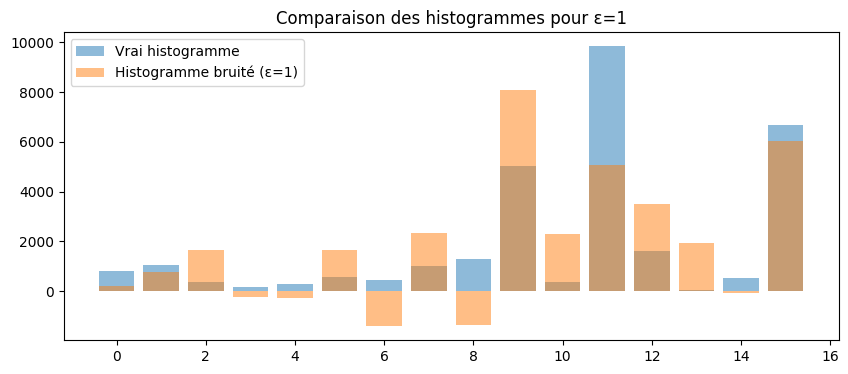

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.bar(range(len(edu_original_data)), edu_original_data, alpha=0.5, label='Vrai histogramme')
plt.bar(range(len(edu_reconstructed)), edu_reconstructed, alpha=0.5, label=f'Histogramme bruité (ε={edu_epsilon})')
plt.title(f'Comparaison des histogrammes pour ε={edu_epsilon}')
plt.legend()
plt.show()


##  II- Experimental Evaluation

#### Q3 - Study the quality of Privelet on query H1

In [20]:
edu_true_histogram

array([ 820, 1048,  377,  151,  288,  557,  455, 1008, 1307, 5044,  375,
       9840, 1627,   45,  542, 6678])

In [21]:
from scipy.stats import wasserstein_distance

def compute_wasserstein(original_hist, perturbed_hist):
    """
    Calcule la distance de Wasserstein entre un histogramme d'origine et un histogramme perturbé.
    """
    return wasserstein_distance(original_hist, perturbed_hist)


In [22]:
def experiment(edu_true_histogram, q3_epsilon_values, num_runs=20):
    # Correction : utiliser epsilon comme clé, pas la liste entière
    wasserstein_distances = {epsilon: [] for epsilon in q3_epsilon_values}

    # Réaliser l'expérience pour chaque valeur de epsilon
    for q3_epsilon_value in q3_epsilon_values:
        print(f"\n=== Traitement pour ε = {q3_epsilon_value} ===")

        # Appliquer la transformation Haar sur les données d'origine
        coefficients = haar_wavelet_transform(edu_true_histogram)

        for _ in range(num_runs):
            # Ajouter du bruit Laplace
            noisy_coefficients = add_laplace_noise(coefficients, q3_epsilon_value)

            # Reconstruire l'histogramme bruité
            noisy_histogram = inverse_haar_wavelet_transform(noisy_coefficients)

            # Calculer la distance de Wasserstein entre l'histogramme original et bruité
            distance = compute_wasserstein(edu_true_histogram, noisy_histogram)
            wasserstein_distances[q3_epsilon_value].append(distance)
            
        # Affichage des résultats pour chaque epsilon après la boucle
        print(f"\nRésultats pour ε = {q3_epsilon_value}:")
        print(f"Moyenne : {np.mean(wasserstein_distances[q3_epsilon_value]):.4f}")
        print(f"Minimale : {np.min(wasserstein_distances[q3_epsilon_value]):.4f}")
        print(f"Maximale : {np.max(wasserstein_distances[q3_epsilon_value]):.4f}")
        
    return wasserstein_distances

In [23]:
def plot_wasserstein_distances(wasserstein_distances, q3_epsilon_values):
    # Calculer les statistiques de la distance de Wasserstein : moyenne, min, max
    avg_distances = [np.mean(wasserstein_distances[q3_epsilon_value]) for q3_epsilon_value in q3_epsilon_values]
    min_distances = [np.min(wasserstein_distances[q3_epsilon_value]) for q3_epsilon_value in q3_epsilon_values]
    max_distances = [np.max(wasserstein_distances[q3_epsilon_value]) for q3_epsilon_value in q3_epsilon_values]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(q3_epsilon_values, avg_distances, label='Moyenne', marker='x', linestyle='-', color='b')
    plt.plot(q3_epsilon_values, min_distances, label='Minimum', marker='*', linestyle='--', color='r')
    plt.plot(q3_epsilon_values, max_distances, label='Maximum', marker='o', linestyle=':', color='g')

    plt.xlabel('Valeur de ε')
    plt.ylabel('Distance de Wasserstein')
    plt.title('Évaluation de Privelet : Variation de la Distance de Wasserstein selon ε')
    plt.legend()
    plt.xscale('log')  # Utiliser une échelle logarithmique pour mieux voir la variation
    plt.grid(True)
    plt.show()

In [24]:

# Histogramme original (edu_true_histogram) à tester
edu_true_histogram = np.array([820, 1048, 377, 151, 288, 557, 455, 1008, 1307, 5044, 375, 9840, 1627, 45, 542, 6678])

# Valeurs de epsilon à tester
q3_epsilon_values = [0.01, 0.1, 1, 10]

# Réaliser l'expérience
wasserstein_distances = experiment(edu_true_histogram, q3_epsilon_values)



=== Traitement pour ε = 0.01 ===

Résultats pour ε = 0.01:
Moyenne : 928.4049
Minimale : 787.0991
Maximale : 1161.0402

=== Traitement pour ε = 0.1 ===

Résultats pour ε = 0.1:
Moyenne : 907.4734
Minimale : 898.3908
Maximale : 919.1766

=== Traitement pour ε = 1 ===

Résultats pour ε = 1:
Moyenne : 904.7139
Minimale : 902.3236
Maximale : 905.8898

=== Traitement pour ε = 10 ===

Résultats pour ε = 10:
Moyenne : 904.7981
Minimale : 904.4944
Maximale : 905.0301


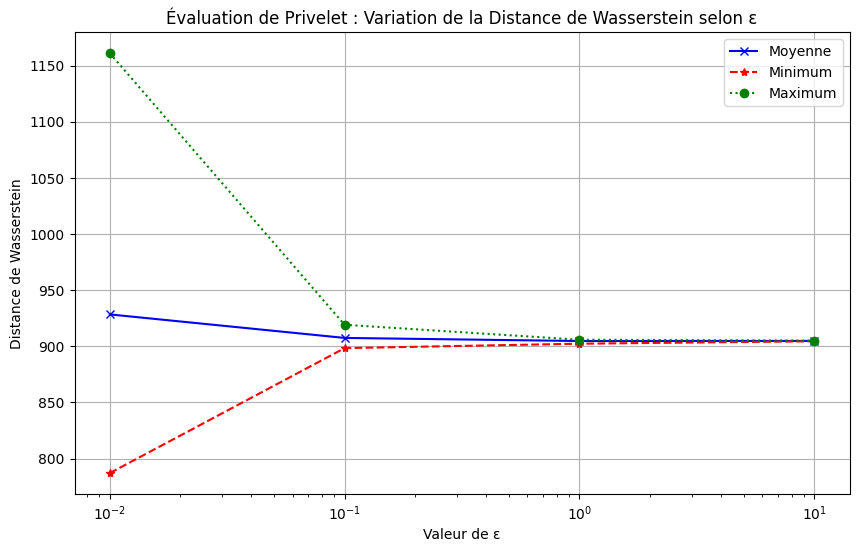

In [25]:
# Afficher les résultats
plot_wasserstein_distances(wasserstein_distances, q3_epsilon_values)

Quand on observe le graphe obtenu :

Pour des petites valeurs de ε (comme ε = 0.01 ou ε = 0.1), la distance de Wasserstein est grande.

Explication : 
Cela signifie que l'histogramme bruité est très différent de l'histogramme original.

Un petit ε signifie plus de bruit ajouté pour garantir une meilleure confidentialité (plus forte protection de la vie privée).

Du coup, les données sont plus déformées, et donc l'erreur (distance) est plus élevée.

Quand ε augmente (par exemple ε = 1 ou ε = 10), la distance de Wasserstein diminue nettement.

Explication :

Un grand ε signifie moins de bruit ajouté, donc les données perturbées sont plus proches des données originales.
La protection de la vie privée est plus faible, mais la qualité des résultats est meilleure (moins d'erreurs).

En résumé :

Petits ε ➔ plus de bruit, plus grande erreur.

Grands ε ➔ moins de bruit, meilleure précision.

La courbe décroît lorsque ε augmente. Les courbes moyenne, minimum et maximum suivent toutes cette tendance.


## Conclusion

La distance de Wasserstein diminue lorsque ε augmente, traduisant un compromis classique entre la protection de la vie privée (plus de bruit pour petit ε) et la qualité des données (moins d'erreur pour grand ε)